<a href="https://colab.research.google.com/github/rgilyard/predict-student-outcomes/blob/main/prelim_gaussian_process_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary Results for a Gaussian Process Classifier for Student Failure and Dropout Prediction

In [100]:
# Train new model? otherwise load
train_model = False

## Constants

In [101]:
DATA_PATH = '/content/drive/MyDrive/COMP 542 Group Project/data/prelim_sample_engineered_student_info_large.csv'
MODEL_PATH = '/content/drive/MyDrive/COMP 542 Group Project/models/gaussian_2023-10-17_21-15-49.joblib'

## Mount Google Drive

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries

In [103]:
import pandas as pd
import numpy as np
import time
import joblib
from datetime import datetime

## Load data

In [104]:
df = pd.read_csv(DATA_PATH)

In [105]:
print(df.head())

   id_student gender                region      highest_education imd_band  \
0       11391      M   East Anglian Region       HE Qualification  90-100%   
1       28400      F              Scotland       HE Qualification   20-30%   
2       30268      F  North Western Region  A Level or Equivalent   30-40%   
3       31604      F     South East Region  A Level or Equivalent   50-60%   
4       32885      F  West Midlands Region     Lower Than A Level   50-60%   

  age_band  num_of_prev_attempts  studied_credits disability final_result  \
0     55<=                     0              240          N         Pass   
1    35-55                     0               60          N         Pass   
2    35-55                     0               60          Y    Withdrawn   
3    35-55                     0               60          N         Pass   
4     0-35                     0               60          N         Pass   

  course_instance  early_assessment_avg  
0       AAA_2013J         

In [106]:
# Drop id column
df.drop(['id_student'], axis=1, inplace=True)

## Preprocessing (These will be moved to a .py file later)

### Combine fail/withdraw and pass/distinction for binary prediction (at first)

In [107]:
df['fail'] = df['final_result'].apply(lambda x: 1 if x in ['Fail', 'Withdrawn'] else 0)

### Split into training and test sets

In [108]:
from sklearn.model_selection import train_test_split

X = df.drop(['final_result', 'fail'], axis=1)  # Dropping the target columns
y = df['fail']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9001)

### Missing values

In [109]:
# Check how many values are missing
print(X_train.isnull().sum())

gender                    0
region                    0
highest_education         0
imd_band                862
age_band                  0
num_of_prev_attempts      0
studied_credits           0
disability                0
course_instance           0
early_assessment_avg     43
dtype: int64


In [110]:
# Since there are not too many missing values, we can take the mode for imd_band
X_train['imd_band'].fillna(X_train['imd_band'].mode()[0], inplace=True)
X_test['imd_band'].fillna(X_test['imd_band'].mode()[0], inplace=True)

# Mean imputation for early assessment grade average
X_train['early_assessment_avg'].fillna(X_train['early_assessment_avg'].mean(), inplace=True)
X_test['early_assessment_avg'].fillna(X_test['early_assessment_avg'].mean(), inplace=True)

print(X_train.isnull().sum())

gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
course_instance         0
early_assessment_avg    0
dtype: int64


### Label encode binary features

In [111]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [112]:
# Lists for each type of feature to encode
# List of binary columns
binary = ['gender', 'disability']

# List of categorical columns
categorical = ['course_instance', 'region']

# List of ordinal columns
ordinal = {'highest_education': [\
              'No Formal quals', \
              'Lower Than A Level', \
              'A Level or Equivalent', \
              'HE Qualification', \
              'Post Graduate Qualification'], \
           'imd_band': [\
              '0-10%', \
              '10-20', \
              '20-30%', \
              '30-40%', \
              '40-50%', \
              '50-60%', \
              '60-70%', \
              '70-80%', \
              '80-90%', \
              '90-100%'], \
           'age_band': [\
              '0-35', \
              '35-55', \
              '55<=']}

In [113]:
# Label encode binary features
label_encoder = LabelEncoder()

for feature in binary:
  label_encoder.fit(X_train[feature])
  X_train[feature] = label_encoder.transform(X_train[feature])
  X_test[feature] = label_encoder.transform(X_test[feature])

In [114]:
# Label encode ordinal features in order
for feature, order in ordinal.items():
  label_encoder = LabelEncoder()
  label_encoder.fit(order)
  X_train[feature] = label_encoder.transform(X_train[feature])
  X_test[feature] = label_encoder.transform(X_test[feature])

In [115]:
# One hot encode categorical features
X_train = pd.get_dummies(X_train, columns=categorical)
X_test = pd.get_dummies(X_test, columns=categorical)

In [116]:
# Because there a some categories with very few instances,
# make sure all the features are in both sets
# Add the missing columns filled with zeros
for col in X_train.columns:
  if col not in X_test.columns:
    X_test[col] = 0

# Reorder test columns to match the order in training set
X_test = X_test[X_train.columns]
print(X_train.head())
feature_names = X_train.columns[X_train.columns != 'fail'].tolist()

       gender  highest_education  imd_band  age_band  num_of_prev_attempts  \
18704       1                  2         8         1                     0   
18059       0                  0         3         0                     1   
10780       1                  0         3         0                     0   
25312       1                  2         7         0                     0   
26409       1                  0         8         0                     0   

       studied_credits  disability  early_assessment_avg  \
18704               60           0             78.333333   
18059               60           0             70.000000   
10780               60           0              0.000000   
25312               90           0             70.000000   
26409              120           0             70.000000   

       course_instance_AAA_2013J  course_instance_AAA_2014J  ...  \
18704                          0                          0  ...   
18059                          0  

# Normalize data

In [117]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_prepared = scaler.fit_transform(X_train)
X_test_prepared = scaler.transform(X_test)

## Train Gaussian Process Model

In [118]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [119]:
# Initialize the Kernel and the Classifiers
# kernel = 1.0 * RBF(1.0)  # RBF kernel with length scale of 1.0
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-6, 1e+6))
gp_classifier = GaussianProcessClassifier(kernel=kernel)

In [120]:
if train_model:
  # Time model training duration
  start_time = time.time()
  start_datetime = datetime.fromtimestamp(start_time)
  print("Start time:", start_datetime.strftime('%Y-%m-%d %H:%M:%S'))
  # Train model
  gp_classifier = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)
  gp_classifier.fit(X_train_prepared, y_train)
  # Record model train duration end time
  end_time = time.time()

In [121]:
if train_model:
  # Save model
  # Get current date and time
  now = datetime.now()
  # Format datetime object to string
  formatted_date_time = now.strftime("%Y-%m-%d_%H-%M-%S")
  # Append datetime to file name
  model_name_with_datetime = f'/content/drive/MyDrive/COMP 542 Group Project/models/gaussian_20000_{formatted_date_time}.joblib'
  joblib.dump(gp_classifier, model_name_with_datetime)
else:
  gp_classifier = joblib.load(MODEL_PATH)

In [122]:
if train_model:
  elapsed_time = end_time - start_time
  print(f"Time taken for training: {elapsed_time:.2f} seconds")

## Evaluate Model

In [123]:
# Evaluate Model
score = gp_classifier.score(X_test_prepared, y_test)
print("Model Accuracy: {:.2f}%".format(score * 100))

Model Accuracy: 71.35%


In [124]:
# Make Predictions
y_prob = gp_classifier.predict_proba(X_test_prepared)[:, 1]  # Probabilities of the positive class

### ROC curve

In [125]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [127]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Compute AUC
roc_auc = auc(fpr, tpr)

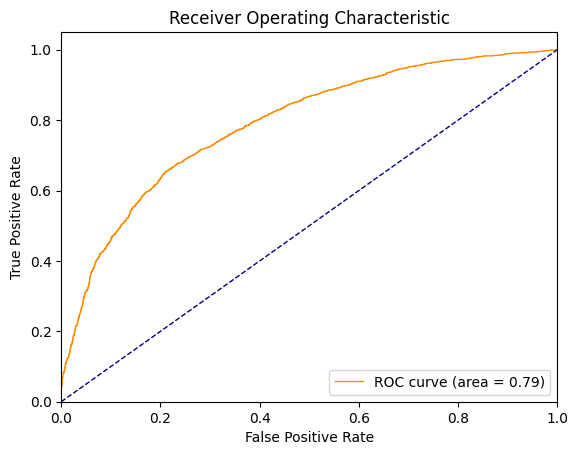

In [128]:
# Plot figure
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Feature Importance

In [129]:
from sklearn.inspection import permutation_importance

# Perform permutation importance
result = permutation_importance(gp_classifier, X_test, y_test, n_repeats=30, random_state=0)

# Get feature importances and their indices
importances = result.importances_mean
sorted_idx = importances.argsort()

In [130]:
# Get feature importances and their indices
importances = result.importances_mean
print(importances)

[-1.62601626e-03  8.19655366e-03  2.65889451e-04 -5.31778903e-04
  6.44781920e-03  9.05046786e-03  1.62601626e-03  1.55591348e-01
  4.41785550e-03  4.16730582e-03  7.61875543e-04  2.19358797e-03
  5.57345196e-04  5.60413151e-03  4.97520070e-03  4.62749911e-03
  7.66988802e-05  6.95403180e-04  1.02265174e-03 -3.06795521e-04
  4.95986092e-04  1.15559646e-03  5.88024748e-04  1.45727872e-03
  4.63261236e-03  2.85319834e-03  4.25423122e-03  6.74950146e-03
  4.30536381e-03  1.02776499e-03  9.71519149e-05  5.31778903e-04
  2.19870123e-03  1.22718208e-04  1.60556323e-03 -7.56762285e-04
 -6.03364524e-04  5.82911489e-04 -8.18121389e-05  3.06795521e-05
 -1.73850795e-04 -7.00516439e-04 -3.88607660e-04]


In [131]:
sorted_idx = importances.argsort()
print(sorted_idx)

[ 0 35 41 36  3 42 19 40 38 39 16 30 33  2 20 31 12 37 22 17 10 18 29 21
 23 34  6 11 32 25  9 26 28  8 15 24 14 13  4 27  1  5  7]


In [132]:
print(result)

{'importances_mean': array([-1.62601626e-03,  8.19655366e-03,  2.65889451e-04, -5.31778903e-04,
        6.44781920e-03,  9.05046786e-03,  1.62601626e-03,  1.55591348e-01,
        4.41785550e-03,  4.16730582e-03,  7.61875543e-04,  2.19358797e-03,
        5.57345196e-04,  5.60413151e-03,  4.97520070e-03,  4.62749911e-03,
        7.66988802e-05,  6.95403180e-04,  1.02265174e-03, -3.06795521e-04,
        4.95986092e-04,  1.15559646e-03,  5.88024748e-04,  1.45727872e-03,
        4.63261236e-03,  2.85319834e-03,  4.25423122e-03,  6.74950146e-03,
        4.30536381e-03,  1.02776499e-03,  9.71519149e-05,  5.31778903e-04,
        2.19870123e-03,  1.22718208e-04,  1.60556323e-03, -7.56762285e-04,
       -6.03364524e-04,  5.82911489e-04, -8.18121389e-05,  3.06795521e-05,
       -1.73850795e-04, -7.00516439e-04, -3.88607660e-04]), 'importances_std': array([0.0009779 , 0.00264411, 0.00217224, 0.00176629, 0.00176484,
       0.00227836, 0.0010348 , 0.00398286, 0.00121653, 0.00102067,
       0.0009865

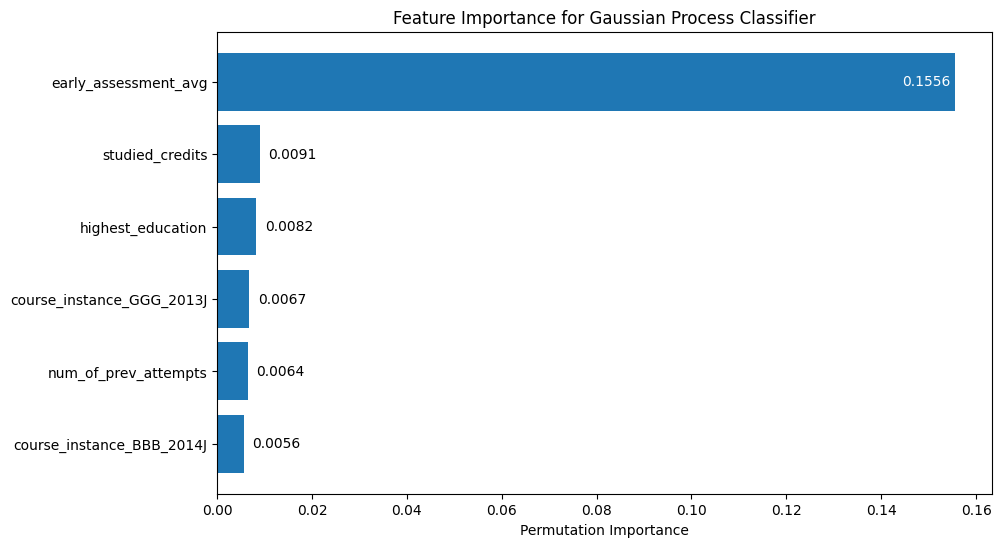

In [133]:
threshold = 0.1  # set a threshold to decide text placement

# Number of top features to display
top_n = 6

# Plotting code, but restricted to 'top_n' most important features
plt.figure(figsize=(10, 6))
bars = plt.barh(range(top_n), importances[sorted_idx][-top_n:])

# Add annotations
for bar in bars:
    bar_width = bar.get_width()
    if bar_width > threshold:
        text_x_position = bar_width - 0.001
        text_color = 'white'
    else:
        text_x_position = bar_width + 0.012
        text_color = 'black'

    plt.text(text_x_position,  # x position
             bar.get_y() + bar.get_height() / 2,  # y position
             f'{bar_width:.4f}',  # text
             va='center',
             ha='right',
             color=text_color)

plt.yticks(range(top_n), [feature_names[i] for i in sorted_idx[-top_n:]])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance for Gaussian Process Classifier')
plt.show()

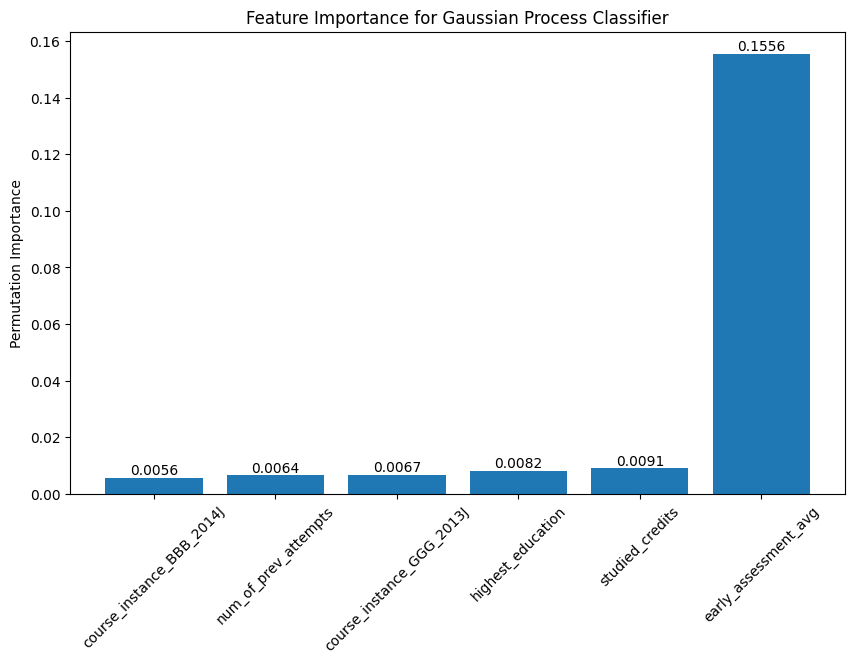

In [134]:
# Same but vertical
plt.figure(figsize=(10, 6))
bars = plt.bar(range(top_n), importances[sorted_idx][-top_n:])

# Add annotations
for bar in bars:
    bar_height = bar.get_height()
    text_y_position = bar.get_y() + bar_height / 2

    plt.text(bar.get_x() + bar.get_width() / 2,  # x position
             bar_height,  # y position
             f'{bar_height:.4f}',  # text
             va='bottom',
             ha='center')

plt.xticks(range(top_n), [feature_names[i] for i in sorted_idx[-top_n:]], rotation=45)
plt.ylabel('Permutation Importance')
plt.title('Feature Importance for Gaussian Process Classifier')
plt.show()

## Generate Radial Basis Similarity Heatmap

In [135]:
from sklearn.gaussian_process.kernels import RBF

In [142]:
print(X_train.columns)

Index(['gender', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'early_assessment_avg', 'course_instance_AAA_2013J',
       'course_instance_AAA_2014J', 'course_instance_BBB_2013B',
       'course_instance_BBB_2013J', 'course_instance_BBB_2014B',
       'course_instance_BBB_2014J', 'course_instance_CCC_2014B',
       'course_instance_CCC_2014J', 'course_instance_DDD_2013B',
       'course_instance_DDD_2013J', 'course_instance_DDD_2014B',
       'course_instance_DDD_2014J', 'course_instance_EEE_2013J',
       'course_instance_EEE_2014B', 'course_instance_EEE_2014J',
       'course_instance_FFF_2013B', 'course_instance_FFF_2013J',
       'course_instance_FFF_2014B', 'course_instance_FFF_2014J',
       'course_instance_GGG_2013J', 'course_instance_GGG_2014B',
       'course_instance_GGG_2014J', 'region_East Anglian Region',
       'region_East Midlands Region', 'region_Ireland', 'region_London Region',
       'region_Nor

In [178]:
# Select a subset of data for better visualization and computational efficiency
subset_idx = np.random.choice(X_train.index.values, 150, replace=False)
# print(type(subset_idx))
# print(subset_idx.max())
# print(subset_idx.min())
# print(X_train.shape)
X_subset = X_train.loc[subset_idx][['studied_credits', 'early_assessment_avg']]
X_subset = X_subset.to_numpy()

In [179]:
# Create the RBF kernel (you can replace it with the kernel you used)
kernel = gp_classifier.kernel_

In [180]:
# Compute the similarity (covariance) matrix
K = kernel(X_subset)

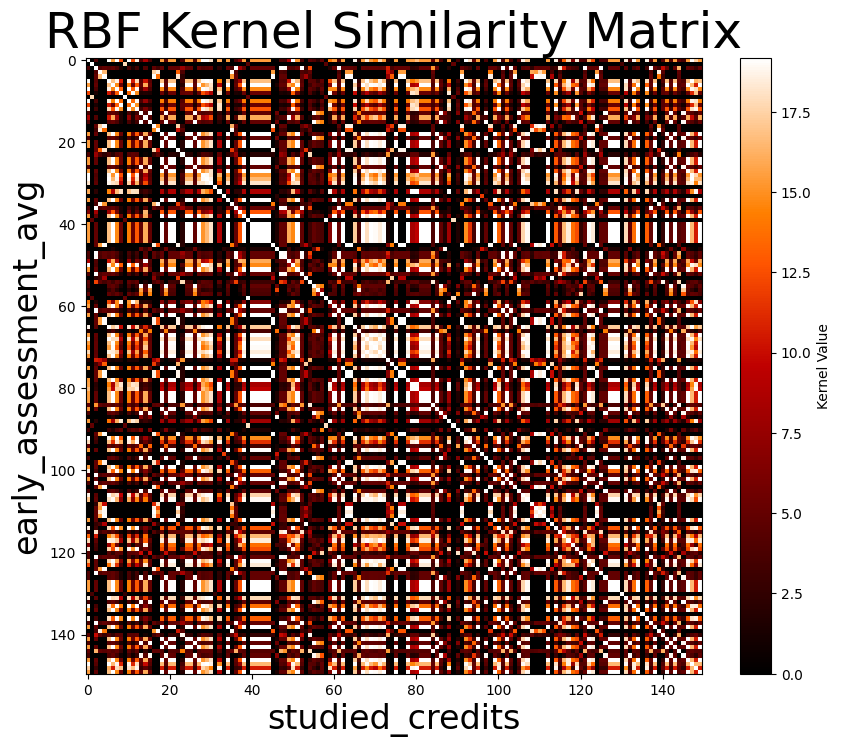

In [181]:
# Plot the similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(K, interpolation='nearest', cmap='gist_heat', origin='upper')
plt.colorbar(label='Kernel Value')
plt.title('RBF Kernel Similarity Matrix', fontsize=36)
plt.xlabel('studied_credits', fontsize=24)
plt.ylabel('early_assessment_avg', fontsize=24)
plt.show()